In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from sklearn.ensemble import IsolationForest

from sklearn.svm import OneClassSVM

### Cargar el Dataset

In [4]:
filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/solar_wind.csv"
dF = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")

df_A = dF.loc[dF['period']=='train_a']
df_A = df_A.dropna()

In [5]:
df_A.describe()

,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature
count,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06,1.394555e+06
mean,-1.800583e+00,3.966949e-01,-1.998417e-01,-9.255569e-01,1.896923e+02,-1.800628e+00,3.517462e-01,-2.199138e-01,-1.035288e+00,1.895481e+02,7.069054e+00,4.898932e+00,4.372335e+02,1.059033e+05
std,4.293035e+00,4.768893e+00,4.339669e+00,3.461554e+01,8.778546e+01,4.293178e+00,4.730183e+00,4.384533e+00,3.509333e+01,8.793808e+01,3.693071e+00,4.834451e+00,9.460213e+01,1.001220e+05
min,-5.463000e+01,-5.169000e+01,-5.305000e+01,-8.989000e+01,0.000000e+00,-5.463000e+01,-5.268000e+01,-5.352000e+01,-8.968000e+01,0.000000e+00,1.400000e-01,0.000000e+00,2.358000e+02,1.000000e+04
25%,-4.940000e+00,-2.760000e+00,-2.660000e+00,-2.563000e+01,1.303800e+02,-4.940000e+00,-2.740000e+00,-2.700000e+00,-2.622500e+01,1.304100e+02,4.920000e+00,2.300000e+00,3.709200e+02,4.363800e+04
50%,-2.020000e+00,5.200000e-01,-1.700000e-01,-1.690000e+00,1.709000e+02,-2.020000e+00,4.600000e-01,-1.700000e-01,-1.760000e+00,1.716600e+02,6.310000e+00,3.630000e+00,4.184600e+02,7.922100e+04
75%,1.500000e+00,3.400000e+00,2.290000e+00,2.352000e+01,2.687400e+02,1.500000e+00,3.310000e+00,2.340000e+00,2.362000e+01,2.680800e+02,8.190000e+00,5.810000e+00,4.847600e+02,1.324900e+05
max,3.289000e+01,4.941000e+01,5.086000e+01,8.987000e+01,3.600000e+02,3.289000e+01,5.291000e+01,4.758000e+01,8.989000e+01,3.600000e+02,7.369000e+01,1.849300e+02,1.011500e+03,6.223700e+06


### Preprocesamiento

Partiendo de la hipótesis de que el dataset no contiene valores anómalos, se deben ingresar manualmente.
Para esto, se selecciona la variable "bt" que corresponde con la magnitud total del campo magnético interplanetario [nT].

Se define la variable "anomaly_factor" para determinar la cantidad de valores anómalos a incorporar al dataset.

Al dataset se le agrega un feature "class" cuyo valor será 1 si el registro contiene un valor anómalo y 0 si el valor del registro es el original del dataset.

In [6]:
features = ['bt']
anomaly_factor = 0.17
# Crear una copia del DataFrame para no modificar el original
df_new = df_A.copy()

for a in features:
  num_replace = int(df_A[a].size * anomaly_factor)

  # Obtener una muestra aleatoria de índices de fila para reemplazar
  replace_idx = np.random.choice(df_A.index, size=num_replace, replace=False)

  # Reemplazar los valores seleccionados con valores aleatorios entre -90 y 1050
  #new_values = np.random.uniform(-90, 1050, size=num_replace)
  new_values = np.random.uniform(0, 75, size=num_replace)
  df_new.loc[replace_idx, a] = new_values

  # Crear la columna "class" con los valores correspondientes
  df_new.loc[df_A[a] != df_new[a], 'class'] = 1
  df_new.loc[df_A[a] == df_new[a], 'class'] = 0

#### Verificación de registros con anomalidades introducidas

In [7]:
print('En el todo el dataset:')
count = (df_new['class'] == 1).sum()
count2 = (df_new['class'] != 1).sum()
print(f'El número de anomalias es {count} y {count2} son valores normales')
cociente = count / (count + count2)
print(f'La relacion de anomalias es {cociente}')

En el todo el dataset:
El número de anomalias es 237074 y 1157481 son valores normales
La relacion de anomalias es 0.16999974902388218


Se divide el Dataset en Train y Test

In [8]:
train_data = df_new.sample(frac=0.8, random_state=0)
test_data = df_new.drop(train_data.index)

#### Train

In [9]:
train_df = pd.DataFrame(train_data, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
print('En el train set:')
count = (train_df['class'] == 1).sum()
count2 = (train_df['class'] != 1).sum()
print(f'El número de anomalias es {count} y {count2} son valores normales')
cociente = count / (count + count2)
print(f'La relacion de anomalias es {cociente}')

En el train set:
El número de anomalias es 189280 y 926364 son valores normales
La relacion de anomalias es 0.16965985565287853


#### Test

In [10]:
test_df = pd.DataFrame(test_data, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
print('En el test:')
count = (test_df['class'] == 1).sum()
count2 = (test_df['class'] != 1).sum()
print(f'El número de anomalias es {count} y {count2} son valores normales')
cociente = count / (count + count2)
print(f'La relacion de anomalias es {cociente}')

En el test:
El número de anomalias es 47794 y 231117 son valores normales
La relacion de anomalias es 0.1713593225078968


Se eliminan los features que no se tendran en cuenta en el entrenamiento del modelo

In [11]:
y = test_data['class']
y_full = test_data
train_data = train_data.drop(["timedelta", "period", "source", 'class'], axis=1)
test_data = test_data.drop(["timedelta", "period", "source", 'class'], axis=1)

Normalización del dataset

In [12]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [13]:
train_data_LSTM = train_data.reshape(train_data.shape[0],1,train_data.shape[1])
test_data_LSTM = test_data.reshape(test_data.shape[0],1,test_data.shape[1])
#train_data_LSTM.shape
#test_data_LSTM.shape

## Modelos

### LSTM Autoencoder

Creación del modelo

In [14]:
input_dim = train_data_LSTM.shape[2]
timesteps = 1

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(32, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(16, activation='relu', return_sequences=False)(encoded)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(input_dim, activation='linear', return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

Entrenamiento del LSTM Autoencoder

In [15]:
autoencoder.fit(train_data_LSTM, train_data_LSTM, epochs=10, batch_size=320, validation_split=0.1)

Epoch 1/10
3138/3138 [==============================] - 24s 6ms/step - loss: 0.1560 - val_loss: 0.0185
Epoch 2/10
3138/3138 [==============================] - 17s 5ms/step - loss: 0.0118 - val_loss: 0.0051
Epoch 3/10
3138/3138 [==============================] - 18s 6ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 4/10
3138/3138 [==============================] - 21s 7ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 5/10
3138/3138 [==============================] - 24s 8ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 6/10
3138/3138 [==============================] - 22s 7ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/10
3138/3138 [==============================] - 19s 6ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 8/10
3138/3138 [==============================] - 21s 7ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 9/10
3138/3138 [==============================] - 23s 7ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/10
3138/3138 [==============================] - 20s 6ms/step - l

In [16]:
predictions_LSTM = autoencoder.predict(test_data_LSTM)

8716/8716 [==============================] - 15s 2ms/step


Evaluación del modelo LSTM Autoencoder

Se comparan las predicciones con los valores reales de "class" para generar una matriz de confusión para evaluar el modelo

In [17]:
threshold_LSTM = 0.01
predictions_LSTM[predictions_LSTM >= threshold_LSTM] = 1
predictions_LSTM[predictions_LSTM < threshold_LSTM] = 0

In [18]:
predictions_LSTM = predictions_LSTM.reshape(predictions_LSTM.shape[0], predictions_LSTM.shape[2])
test_data = test_data.reshape(test_data_LSTM.shape[0], test_data_LSTM.shape[2])
y_full = y_full.to_numpy()
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_LSTM[:, 10], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted     0.0    1.0
Actual                  
0.0        215100  16017
1.0          7971  39823


In [19]:
pd_predictions_LSTM = pd.DataFrame(predictions_LSTM)
column_10 = predictions_LSTM[:, 10]
is_one_LSTM = column_10 ==1
# Asignar 1 a los elementos que sean True y 0 a los elementos que sean False
has_ones_LSTM = np.where(is_one_LSTM, 1, 0)

In [20]:
has_ones_LSTM_pd = pd.DataFrame(has_ones_LSTM, columns=['class'])
count = (has_ones_LSTM_pd['class'] == 1).sum()
count1 = (has_ones_LSTM_pd['class'] == 0).sum()
print(f'El número de anomalias es {count} y {count1} son valores normales')

El número de anomalias es 55840 y 223071 son valores normales


In [21]:
new_column_LSTM = has_ones_LSTM
# Agregar la nueva columna al final del ndarray original
predictions_class_LSTM = np.hstack((predictions_LSTM, new_column_LSTM.reshape(-1, 1)))

In [22]:
new_column_LSTM_df = pd.DataFrame(new_column_LSTM, columns =['class'])
count3 = (new_column_LSTM_df['class'] == True).sum()
count4 = (new_column_LSTM_df['class'] == False).sum()
print(f'El número de anomalias es {count3} y {count4} son valores normales')

El número de anomalias es 55840 y 223071 son valores normales


In [23]:
pd_predictions_LSTM = pd.DataFrame(predictions_class_LSTM)

In [24]:
pd_test_data = pd.DataFrame(test_data)

In [25]:
from sklearn.metrics import classification_report
 
print(classification_report(predictions_class_LSTM[:,14], y))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95    223071
         1.0       0.83      0.71      0.77     55840

    accuracy                           0.91    278911
   macro avg       0.88      0.84      0.86    278911
weighted avg       0.91      0.91      0.91    278911



In [26]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.show()

In [27]:
y_pd = pd.DataFrame(y, columns = ['class'])
count = (y_pd['class'] == 1).sum()
print(f'El número de anomalias reales es {count}')

El número de anomalias reales es 47794


In [28]:
predictions_class__LSTM_pd  = pd.DataFrame(predictions_class_LSTM, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
count = (predictions_class__LSTM_pd['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 55840


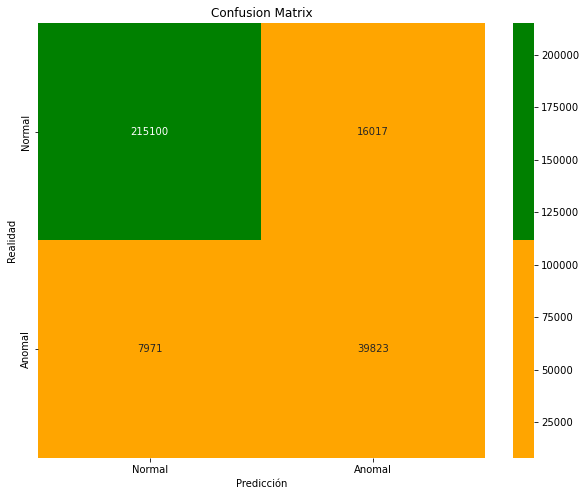

In [29]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, predictions_class_LSTM[:,14])

### RBM

Creación del modelo

In [30]:
model_rbm = Sequential()
model_rbm.add(Dense(20, input_shape=(train_data.shape[1],), activation='sigmoid'))
model_rbm.add(Dense(train_data.shape[1], activation='sigmoid'))
model_rbm.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

Entreno el modelo Restricted Boltzmann Machine

In [31]:
model_rbm.fit(train_data, train_data, epochs=20, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/20
31378/31378 [==============================] - 36s 1ms/step - loss: 0.5777 - val_loss: 0.5756
Epoch 2/20
31378/31378 [==============================] - 33s 1ms/step - loss: 0.5741 - val_loss: 0.5749
Epoch 3/20
31378/31378 [==============================] - 29s 914us/step - loss: 0.5736 - val_loss: 0.5747
Epoch 4/20
31378/31378 [==============================] - 34s 1ms/step - loss: 0.5735 - val_loss: 0.5746
Epoch 5/20
31378/31378 [==============================] - 33s 1ms/step - loss: 0.5735 - val_loss: 0.5747
Epoch 6/20
31378/31378 [==============================] - 41s 1ms/step - loss: 0.5734 - val_loss: 0.5745
Epoch 7/20
31378/31378 [==============================] - 39s 1ms/step - loss: 0.5734 - val_loss: 0.5745
Epoch 8/20
31378/31378 [==============================] - 36s 1ms/step - loss: 0.5734 - val_loss: 0.5745
Epoch 9/20
31378/31378 [==============================] - 29s 923us/step - loss: 0.5734 - val_loss: 0.5745
Epoch 10/20
31378/31378 [==========================

In [32]:
predictions_rbm = model_rbm.predict(test_data)

8716/8716 [==============================] - 6s 698us/step


Evaluación del modelo rbm

In [33]:
threshold_rbm = 0.05
predictions_rbm[predictions_rbm >= threshold_rbm] = 1
predictions_rbm[predictions_rbm < threshold_rbm] = 0

In [34]:
#y_full = y_full.to_numpy()
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_rbm[:, 10], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted     0.0    1.0
Actual                  
0.0        222309   8808
1.0          9673  38121


In [35]:
pd_predictions = pd.DataFrame(predictions_rbm)
column_10_rbm = predictions_rbm[:, 10]
is_one_rbm = column_10_rbm ==1
# Asignar 1 a los elementos que sean True y 0 a los elementos que sean False
has_ones_rbm = np.where(is_one_rbm, 1, 0)

In [36]:
has_ones_rbm_pd = pd.DataFrame(has_ones_rbm, columns=['class'])
count = (has_ones_rbm_pd['class'] == 1).sum()
count1 = (has_ones_rbm_pd['class'] == 0).sum()
print(f'El número de anomalias predecidas es {count} y {count1} son valores normales')

El número de anomalias predecidas es 46929 y 231982 son valores normales


In [37]:
new_column_rbm = has_ones_rbm
new_column_rbm.shape

(278911,)

In [38]:
predictions_class_rbm = np.hstack((predictions_rbm, new_column_rbm.reshape(-1, 1)))

In [39]:
pd_predictions_rbm = pd.DataFrame(predictions_class_rbm)

In [40]:
from sklearn.metrics import classification_report
 
print(classification_report(predictions_class_rbm[:,14], y))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    231982
         1.0       0.80      0.81      0.80     46929

    accuracy                           0.93    278911
   macro avg       0.88      0.89      0.88    278911
weighted avg       0.93      0.93      0.93    278911



In [41]:
predictions_class_rbm_pd  = pd.DataFrame(predictions_class_rbm, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
count = (predictions_class_rbm_pd['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 46929


In [42]:
predictions_class_rbm

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [44]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.show()

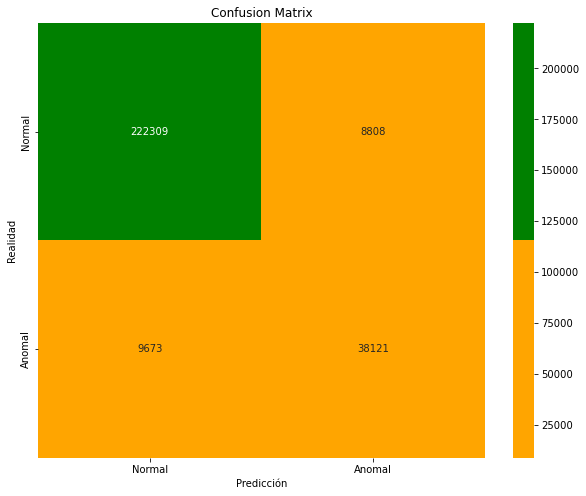

In [45]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, predictions_class_rbm[:,14])

### Isolation Forest

Creación del modelo

In [46]:
model_if = IsolationForest(n_estimators=100, contamination='auto', random_state=0)

Entreno el modelo

In [47]:
model_if.fit(train_data,train_data)

IsolationForest(random_state=0)

In [48]:
predictions_if = model_if.predict(test_data)

Evaluación del modelo Isolation Forest

In [49]:
threshold_if = 0.05
predictions_if[predictions_if >= threshold_if] = 1
predictions_if[predictions_if < threshold_if] = 0

In [50]:
#y_full = y_full.to_numpy()
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_if, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted      0       1
Actual                  
0.0        20817  210300
1.0        10023   37771


In [51]:
pd_predictions_if = pd.DataFrame(predictions_if, columns=['class'])
count = (pd_predictions_if['class'] == 1).sum()
count1 = (pd_predictions_if['class'] == 0).sum()
print(f'El número de anomalias predecidas es {count} y {count1} valores normales')

El número de anomalias predecidas es 248071 y 30840 valores normales


In [52]:
print(classification_report(pd_predictions_if, y))

              precision    recall  f1-score   support

           0       0.09      0.68      0.16     30840
           1       0.79      0.15      0.26    248071

    accuracy                           0.21    278911
   macro avg       0.44      0.41      0.21    278911
weighted avg       0.71      0.21      0.24    278911



In [53]:
y_pd = pd.DataFrame(y, columns = ['class'])
count = (y_pd['class'] == 1).sum()
print(f'El número de anomalias reales es {count}')

El número de anomalias reales es 47794


In [54]:
count = (pd_predictions_if['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 248071


In [55]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.show()

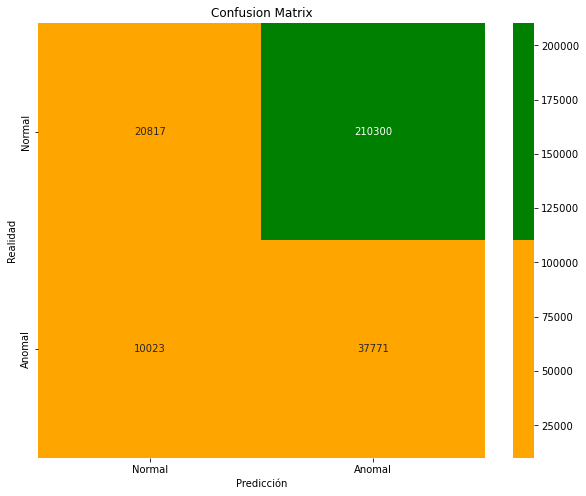

In [56]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, pd_predictions_if)

### Support Vector Machines

Creación del modelo

In [57]:
model_svm = OneClassSVM(kernel='rbf', nu=0.01)

Entreno el modelo

In [58]:
model_svm.fit(train_data)

OneClassSVM(nu=0.01)

In [59]:
predictions_svm = model_svm.predict(test_data)

Evaluación del Modelo Support Vector Machines

In [60]:
predictions_svm[predictions_svm == 1] = 0
predictions_svm[predictions_svm == -1] = 1

In [61]:
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_svm, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted       0     1
Actual                 
0.0        229082  2035
1.0         46917   877


In [62]:
pd_predictions_svm = pd.DataFrame(predictions_svm, columns=['class'])
count = (pd_predictions_svm['class'] == 1).sum()
count1 = (pd_predictions_svm['class'] == 0).sum()
print(f'El número de anomalias predecidas es {count} y {count1} valores normales')

El número de anomalias predecidas es 2912 y 275999 valores normales


In [63]:
print(classification_report(pd_predictions_svm, y))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    275999
           1       0.02      0.30      0.03      2912

    accuracy                           0.82    278911
   macro avg       0.50      0.57      0.47    278911
weighted avg       0.98      0.82      0.89    278911



In [64]:
y_pd = pd.DataFrame(y, columns = ['class'])
count = (y_pd['class'] == 1).sum()
print(f'El número de anomalias reales es {count}')

El número de anomalias reales es 47794


In [65]:
count = (pd_predictions_svm['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 2912


In [66]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.show()

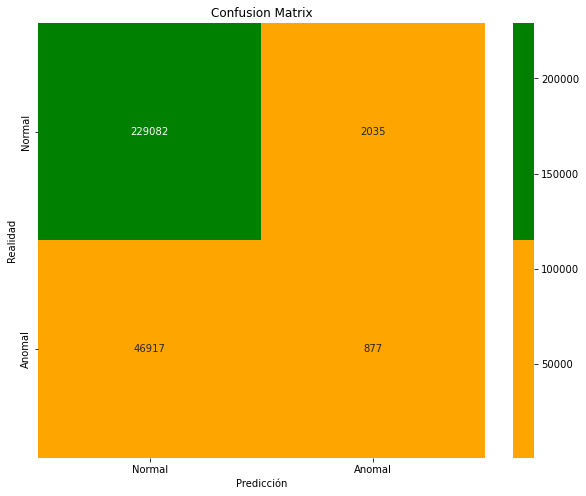

In [67]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, pd_predictions_svm)

## Gráficos y evaluación con AUC

In [68]:
clase = y_full[:,-1].astype(int)

In [69]:
from sklearn.metrics import roc_auc_score

# Calcular el AUC para cada modelo utilizando la función roc_auc_score() de la biblioteca scikit-learn
LSTM_auc = roc_auc_score(clase, predictions_class_LSTM[:,14])
rbm_auc = roc_auc_score(clase, predictions_class_rbm[:,14])
if_auc = roc_auc_score(clase, predictions_if)
svm_auc = roc_auc_score(clase, predictions_svm)
print("AUC de LSTM Autoencoder:", LSTM_auc)
print("AUC de Restricted Bolztmann Machine:", rbm_auc)
print("AUC de Isolation Forest:", if_auc)
print("AUC de Suport Vector Machines:", svm_auc)

AUC de LSTM Autoencoder: 0.8819595911372743
AUC de Restricted Bolztmann Machine: 0.8797500056793832
AUC de Isolation Forest: 0.44017937319591316
AUC de Suport Vector Machines: 0.5047722597640062


In [70]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [71]:
rbm_fpr, rbm_tpr, _ = roc_curve(clase, predictions_class_rbm[:,14])
rbm_auc = auc(rbm_fpr, rbm_tpr)

In [72]:
LSTM_fpr, LSTM_tpr, _ = roc_curve(clase, predictions_class_LSTM[:,14])
LSTM_auc = auc(LSTM_fpr, LSTM_tpr)

In [73]:
if_fpr, if_tpr, _ = roc_curve(clase, predictions_if)
if_auc = auc(if_fpr, if_tpr)

In [74]:
svm_fpr, svm_tpr, _ = roc_curve(clase, predictions_svm)
svm_auc = auc(svm_fpr, svm_tpr)

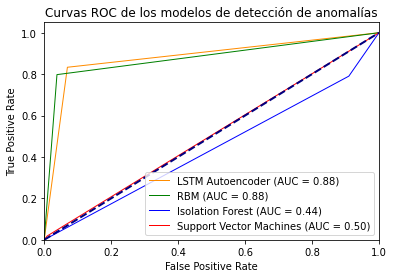

In [78]:
plt.figure()
plt.plot(LSTM_fpr, LSTM_tpr, color='darkorange', lw=1, label='LSTM Autoencoder (AUC = %0.2f)' % LSTM_auc)
plt.plot(rbm_fpr, rbm_tpr, color='green', lw=1, label='RBM (AUC = %0.2f)' % rbm_auc)
plt.plot(if_fpr, if_tpr, color='blue', lw=1, label='Isolation Forest (AUC = %0.2f)' % if_auc)
plt.plot(svm_fpr, svm_tpr, color='red', lw=1, label='Support Vector Machines (AUC = %0.2f)' % svm_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC de los modelos de detección de anomalías')
plt.legend(loc="lower right")
plt.show()